In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

'''mnist = fetch_openml('mnist_784', version=1)
X = mnist['data']
y = mnist['target']'''

mnist_data = np.load('/content/drive/MyDrive/2l/dataset.npz')
images = mnist_data['images']
labels = mnist_data['labels']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(images, labels, test_size=0.1)

X_train_1 = X_train_1.astype(np.float32)
X_test_1 = X_test_1.astype(np.float32)
y_train_1 = y_train_1.astype(np.long)
y_test_1 = y_test_1.astype(np.long)



<ipython-input-3-3e46d634084f>:17: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train_1 = y_train_1.astype(np.long)
<ipython-input-3-3e46d634084f>:18: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compa

In [ ]:
unique, counts = np.unique(y_test_1, return_counts=True)
dict(zip(unique, counts))

{0: 44, 1: 33, 2: 31, 3: 32, 4: 43, 5: 29, 6: 37, 7: 53, 8: 41, 9: 45}

In [ ]:
import torch

# Convert X_train to a PyTorch tensor.
X_train = torch.from_numpy(X_train_1)
# Permute the dimensions from [n, 25, 25, 3] to [n, 3, 25, 25].
X_train = X_train.permute(0, 3, 1, 2)


# Convert X_test to a PyTorch tensor.
X_test = torch.from_numpy(X_test_1)
# Permute the dimensions from [n, 25, 25, 3] to [n, 3, 25, 25].
X_test = X_test.permute(0, 3, 1, 2)



# Convert y_train to a PyTorch tensor
y_train = torch.from_numpy(y_train_1)

# Convert y_test to a PyTorch tensor
y_test = torch.from_numpy(y_test_1)




In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
X_train.shape

torch.Size([3490, 3, 25, 25])

In [ ]:
# Số classes trong tập MNIST
num_classes = 10

# Số epoch
epochs = 10

# Các tham số cần thiết trong quá trình training
learning_rate = 0.001
batch_size = 64
display_step = 10

# Model path
checkpoint = 'model.pth'

# device: cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.8)
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=9*9*64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        ### START CODE HEAR ≈ 18 lines
        ## 3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        ### END CODE HERE
        return x

In [ ]:
# Load model vào GPU
model = Net().to(device)
summary(model, (3, 25, 25))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 23, 23]             896
              ReLU-2           [-1, 32, 23, 23]               0
            Conv2d-3           [-1, 64, 21, 21]          18,496
              ReLU-4           [-1, 64, 21, 21]               0
            Conv2d-5           [-1, 64, 19, 19]          36,928
              ReLU-6           [-1, 64, 19, 19]               0
         MaxPool2d-7             [-1, 64, 9, 9]               0
           Dropout-8             [-1, 64, 9, 9]               0
           Flatten-9                 [-1, 5184]               0
           Linear-10                  [-1, 128]         663,680
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam Optimizer set params=model.parameters(), lr=learning_rate
best_val_loss = 999

# Loop for each epoch
for epoch in range(1, epochs + 1):

    # Quá trình training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Load dữ liệu vào GPU
        data, target = data.to(device), target.to(device)

        # Clear gradients cho mỗi batch
        optimizer.zero_grad() # zero grad
        output = model(data)

        # Backpropagation, tính gradients
        loss = criterion(output, target)
        loss.backward() #backward

        # Apply gradients để update lại tham số
        optimizer.step()
        if batch_idx % display_step == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # Quá trình testing
    model.eval()
    test_loss = 0
    correct = 0

    # Set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            # Load dữ liệu vào GPU
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = F.log_softmax(output,dim=1) # sử dụng hàm log_sotmax của pytorch để tính xác suất cho output, dim = 1
            test_loss += criterion(output, target)
            pred = output.argmax(dim = 1, keepdim = True) # Sử dụng hàm argmax để lấy predicted label, chú ý keepdim=True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model.state_dict(), checkpoint)  # Lưu model path
      print("***********    TEST_ACC = {:.2f}%    ***********".format(correct/100))

Train Epoch 1: [0/3490 (0%)]	Train Loss: 6.553298
Train Epoch 1: [320/3490 (9%)]	Train Loss: 2.306679
Train Epoch 1: [640/3490 (18%)]	Train Loss: 2.311445
Train Epoch 1: [960/3490 (27%)]	Train Loss: 2.226202
Train Epoch 1: [1280/3490 (36%)]	Train Loss: 2.223166
Train Epoch 1: [1600/3490 (45%)]	Train Loss: 2.230277
Train Epoch 1: [1920/3490 (55%)]	Train Loss: 2.154254
Train Epoch 1: [2240/3490 (64%)]	Train Loss: 1.810906
Train Epoch 1: [2560/3490 (73%)]	Train Loss: 1.582484
Train Epoch 1: [2880/3490 (82%)]	Train Loss: 1.810410
Train Epoch 1: [3200/3490 (91%)]	Train Loss: 1.700886
***********    TEST_ACC = 2.11%    ***********
Train Epoch 2: [0/3490 (0%)]	Train Loss: 1.573705
Train Epoch 2: [320/3490 (9%)]	Train Loss: 1.034598
Train Epoch 2: [640/3490 (18%)]	Train Loss: 1.595805
Train Epoch 2: [960/3490 (27%)]	Train Loss: 1.387930
Train Epoch 2: [1280/3490 (36%)]	Train Loss: 1.601866
Train Epoch 2: [1600/3490 (45%)]	Train Loss: 1.095042
Train Epoch 2: [1920/3490 (55%)]	Train Loss: 1.0961

In [ ]:
# Load lại model đã train
model.load_state_dict(torch.load(checkpoint))

# Xem lại thông số của model
model.eval()

Net(
  (relu): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
symbol_dict = {'0':'α',
	       '1':'β',
		   '2':'γ',
		   '3':'δ',
		   '4':'λ',
		   '5':'μ',
		   '6':'Ω',
		   '7':'π',
		   '8':'φ',
			'9':'θ'}

In [ ]:
# Lấy ra một batch trong tập test
item = iter(test_loader)
data, target = next(item)

# Lấy random index của một phần tử trong batch đó
test_idx = random.choice(range(len(data)))

# Lấy một ví dụ trong tập test
data = data[test_idx]
target = target[test_idx]
assert data.shape == (3, 25, 25)

In [ ]:
# Predict sử dụng model đã train
def plot(data, model):
  data = torch.unsqueeze(data, dim=0) # unsqueeze data
  data = data.to(device)
  output = model(data)
  output = F.log_softmax(output, dim=1) # log softmax, chú ý dim
  pred = output.argmax(dim=1, keepdim=True) # argmax, chú ý keepdim, dim=1
  print("Predict Number : ", symbol_dict[str(pred[0][0].detach().cpu().numpy())])
  plt.imshow(data[0][0].detach().cpu().numpy(), cmap='gray')
  plt.show()

In [ ]:
# Lấy ra một batch trong tập test
item = iter(test_loader)
data, target = next(item)

# Lấy random index của một phần tử trong batch đó
test_idx = random.choice(range(len(data)))

# Lấy một ví dụ trong tập test
data = data[test_idx]
target = target[test_idx]
assert data.shape == (3, 25, 25)
plot(data, model)

In [ ]:
import torch
from PIL import Image
import numpy as np

# Load the PyTorch model from the .pth file
model_1 = torch.load('model.pth')

# Load the image and convert it to a grayscale numpy array
img = Image.open("/content/1e1 (1).png")
img_array = np.array(img)
img_array = img_array.astype(np.float32) /255.0
img_array = torch.from_numpy(img_array)
data = img_array.permute(2, 0, 1)

Predict Number :  λ


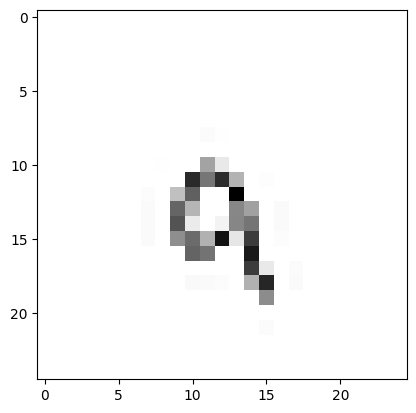

In [ ]:
plot(data, model)